In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import numpy as np

# Load and normalize data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten images
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Encoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
output_img = Dense(784, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

In [4]:
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0958 - val_loss: 0.0371
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0340 - val_loss: 0.0266
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0255 - val_loss: 0.0219
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0219 - val_loss: 0.0198
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0197 - val_loss: 0.0178
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0177 - val_loss: 0.0162
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0146 - val_loss: 0.0139
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


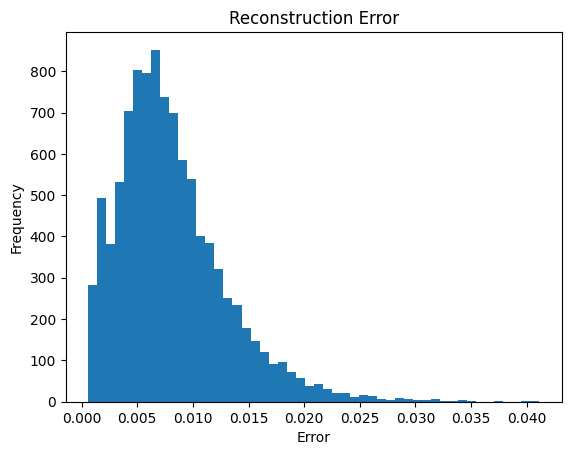

In [6]:
import matplotlib.pyplot as plt

X_pred = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - X_pred, 2), axis=1)

plt.hist(mse, bins=50)
plt.title("Reconstruction Error")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Save model
autoencoder.save("autoencoder_model.h5")

# Save scaler
import joblib
joblib.dump(scaler, "scaler.pkl")


In [ ]:
# a. Batch Inference Script
from tensorflow.keras.models import load_model
import numpy as np
import joblib

# Load saved components
model = load_model("autoencoder_model.h5")
scaler = joblib.load("scaler.pkl")

# Example new data
new_data = np.random.rand(5, 20)
new_data_scaled = scaler.transform(new_data)

# Predict
reconstructed = model.predict(new_data_scaled)
errors = np.mean(np.power(new_data_scaled - reconstructed, 2), axis=1)

print("Reconstruction errors:", errors)


# b. REST API with FastAPI
from fastapi import FastAPI
import uvicorn
from pydantic import BaseModel
import numpy as np
from tensorflow.keras.models import load_model
import joblib

app = FastAPI()
model = load_model("autoencoder_model.h5")
scaler = joblib.load("scaler.pkl")

class InputData(BaseModel):
    features: list

@app.post("/predict")
def predict(data: InputData):
    X = np.array([data.features])
    X_scaled = scaler.transform(X)
    X_reconstructed = model.predict(X_scaled)
    error = np.mean(np.power(X_scaled - X_reconstructed, 2), axis=1)[0]
    return {"reconstruction_error": float(error)}

# Run with: uvicorn filename:app --reload
